In [1]:
!pip install -q efficientnet

In [2]:
import math, re, gc
import numpy as np # linear algebra
import pickle
from datetime import datetime, timedelta
import tensorflow as tf
import efficientnet.tfkeras as efficientnet
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print('TensorFlow version', tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

TensorFlow version 2.1.0


In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print('Replicas:', strategy.num_replicas_in_sync)

GCS_DS_PATH = KaggleDatasets().get_gcs_path('flower-classification-with-tpus')
MORE_IMAGES_GCS_DS_PATH = KaggleDatasets().get_gcs_path('tf-flower-photo-tfrec')
print(GCS_DS_PATH, '\n', MORE_IMAGES_GCS_DS_PATH)

Running on TPU grpc://10.0.0.2:8470
Replicas: 8
gs://kds-00678dcb48cf1620abe5f19efdc3a50cd7949306c3125d21fa910615 
 gs://kds-7912d38da4ad3ef68d1da361c2c13bda73f16a5b896b494492cae94b


In [4]:
start_time = datetime.now()
print('Time now is', start_time)
end_training_by_tdelta = timedelta(seconds=8400)
this_run_file_prefix = start_time.strftime('%Y%m%d_%H%M_')
print(this_run_file_prefix)

IMAGE_SIZE = [512, 512] 

BATCH_SIZE = 16 * strategy.num_replicas_in_sync

GCS_PATH_SELECT = {
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')

MOREIMAGES_PATH_SELECT = {
    192: '/tfrecords-jpeg-192x192',
    224: '/tfrecords-jpeg-224x224',
    331: '/tfrecords-jpeg-331x331',
    512: '/tfrecords-jpeg-512x512'
}
MOREIMAGES_PATH = MOREIMAGES_PATH_SELECT[IMAGE_SIZE[0]]

IMAGENET_FILES = tf.io.gfile.glob(MORE_IMAGES_GCS_DS_PATH + '/imagenet' + MOREIMAGES_PATH + '/*.tfrec')
INATURELIST_FILES = tf.io.gfile.glob(MORE_IMAGES_GCS_DS_PATH + '/inaturalist' + MOREIMAGES_PATH + '/*.tfrec')
OPENIMAGE_FILES = tf.io.gfile.glob(MORE_IMAGES_GCS_DS_PATH + '/openimage' + MOREIMAGES_PATH + '/*.tfrec')
OXFORD_FILES = tf.io.gfile.glob(MORE_IMAGES_GCS_DS_PATH + '/oxford_102' + MOREIMAGES_PATH + '/*.tfrec')
TENSORFLOW_FILES = tf.io.gfile.glob(MORE_IMAGES_GCS_DS_PATH + '/tf_flowers' + MOREIMAGES_PATH + '/*.tfrec')
ADDITIONAL_TRAINING_FILENAMES = IMAGENET_FILES + INATURELIST_FILES + OPENIMAGE_FILES + OXFORD_FILES + TENSORFLOW_FILES
#print(VALIDATION_FILENAMES)
print('----')
TRAINING_FILENAMES = TRAINING_FILENAMES + ADDITIONAL_TRAINING_FILENAMES
#print(TRAINING_FILENAMES)

# This is so awkward. Everyone is doing this for an extra few points.
# TRAINING_FILENAMES = TRAINING_FILENAMES + VALIDATION_FILENAMES
# VALIDATION_FILENAMES = TRAINING_FILENAMES

CLASSES = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'wild geranium', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', # 00 - 09
           'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', # 10 - 19
           'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', # 20 - 29
           'carnation', 'garden phlox', 'love in the mist', 'cosmos', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', # 30 - 39
           'barberton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'daisy', 'common dandelion', # 40 - 49
           'petunia', 'wild pansy', 'primula', 'sunflower', 'lilac hibiscus', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia', # 50 - 59
           'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum', 'spring crocus', 'iris', 'windflower', 'tree poppy', # 60 - 69
           'gazania', 'azalea', 'water lily', 'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium', # 70 - 79
           'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen ', 'watercress', 'canna lily', # 80 - 89
           'hippeastrum ', 'bee balm', 'pink quill', 'foxglove', 'bougainvillea', 'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower', # 90 - 99
           'trumpet creeper', 'blackberry lily', 'common tulip', 'wild rose'] # 100 - 102

Time now is 2020-05-08 17:12:40.663038
20200508_1712_
----


In [5]:
LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = LR_START
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0 # 3
LR_EXP_DECAY = 0.80

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = LR_START + (epoch * (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS)
    elif epoch < (LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS):
        lr = LR_MAX
    else:
        lr = LR_MIN + (LR_MAX - LR_MIN) * LR_EXP_DECAY ** (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)
#    print('For epoch', epoch, 'setting lr to', lr)
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(20)]
y = [lrfn(x) for x in rng]
print(y)

[1e-05, 8.8e-05, 0.000166, 0.000244, 0.000322, 0.0004, 0.000322, 0.0002596000000000001, 0.00020968000000000004, 0.00016974400000000002, 0.00013779520000000003, 0.00011223616000000004, 9.178892800000003e-05, 7.543114240000003e-05, 6.234491392000002e-05, 5.1875931136000024e-05, 4.3500744908800015e-05, 3.6800595927040014e-05, 3.1440476741632015e-05, 2.7152381393305616e-05]


In [6]:
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object:
        numpy_labels = [None for _ in enumerate(numpy_images)]
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [7]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image
#

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'class': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label
#

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'id': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum
#

def load_dataset(filenames, labeled = True, ordered = False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls = AUTO)
    return dataset
#

def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0, 2)
    return image, label
#

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset
#

def get_validation_dataset(ordered = False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled = True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset
#

def get_test_dataset(ordered = False):
    dataset = load_dataset(TEST_FILENAMES, labeled = False, ordered = ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset
#

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)
#

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 68094 training images, 3712 validation images, 7382 unlabeled test images


In [8]:
print('Training data shapes')
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print('Training data label examples:', label.numpy())
#

print('Validation data shapes')
for image, label in get_validation_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print('Validation data label examples:', label.numpy())
#

print('Test data shapes')
for image, idnum in get_test_dataset().take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print('Test data IDs:', idnum.numpy().astype('U'))

Training data shapes
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Training data label examples: [ 53 100  72 ...  79  67  45]
Validation data shapes
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Validation data label examples: [14 71 18 ... 82 24 13]
Test data shapes
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Test data IDs: ['4bfdc5664' '954d0fe63' 'dd7ae60d1' ... '06291a920' '774e6e2a9' 'f638a96fd']


In [9]:
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

In [10]:
test_dataset = get_test_dataset()
test_dataset = test_dataset.unbatch().batch(20)
test_batch = iter(test_dataset)

In [11]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights = True)

In [12]:
def create_EfficientNet_model():
    pretrained_model = efficientnet.EfficientNetB7(weights = 'noisy-student', include_top = False, input_shape = [*IMAGE_SIZE, 3])
    pretrained_model.trainable = True

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation = 'softmax')
    ])

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])
    return model

In [13]:
with strategy.scope():
    model = create_EfficientNet_model()
model_name = model.layers[0].name
model.summary()

258072576/258068648 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 16, 16, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               266344    
Total params: 64,364,024
Trainable params: 64,053,304
Non-trainable params: 310,720
_________________________________________________________________


In [14]:
model_name

'efficientnet-b7'

In [15]:
class TimeCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}):
        if((datetime.now() - start_time).total_seconds() > 9500):
            self.model.stop_training = True
            
time_callback = TimeCallback()

In [16]:
%%time

EPOCHS = 30 # 30 # 50 # 35 # 2 # 20

print('LR_EXP_DECAY:', LR_EXP_DECAY, '. LR_MAX:', LR_MAX)
history = model.fit(get_training_dataset(), steps_per_epoch = STEPS_PER_EPOCH, epochs = EPOCHS, validation_data = get_validation_dataset(), callbacks = [lr_callback, early_stop, time_callback])

LR_EXP_DECAY: 0.8 . LR_MAX: 0.0004
Train for 531 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/30
531/531 [==============================] - 836s 2s/step - loss: 4.1290 - sparse_categorical_accuracy: 0.1477 - val_loss: 3.9315 - val_sparse_categorical_accuracy: 0.2206

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/30
531/531 [==============================] - 528s 994ms/step - loss: 1.3253 - sparse_categorical_accuracy: 0.6945 - val_loss: 0.6755 - val_sparse_categorical_accuracy: 0.8149

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/30
531/531 [==============================] - 524s 987ms/step - loss: 0.5560 - sparse_categorical_accuracy: 0.8576 - val_loss: 0.4288 - val_sparse_categorical_accuracy: 0.8909

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/30
531/531 [==============================] - 525s 988ms/step - loss: 0.4153 - sparse_categorical_accura

In [17]:
cmdataset = get_validation_dataset(ordered = True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()

In [18]:
%%time

test_ds = get_test_dataset(ordered = True)
#print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

Cause: Unable to locate the source code of <function <lambda> at 0x7f7d9054b268>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
Cause: Unable to locate the source code of <function <lambda> at 0x7f7da015f400>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
CPU times: user 50.6 ms, sys: 19.3 ms, total: 69.9 ms
Wall time: 3.45 s


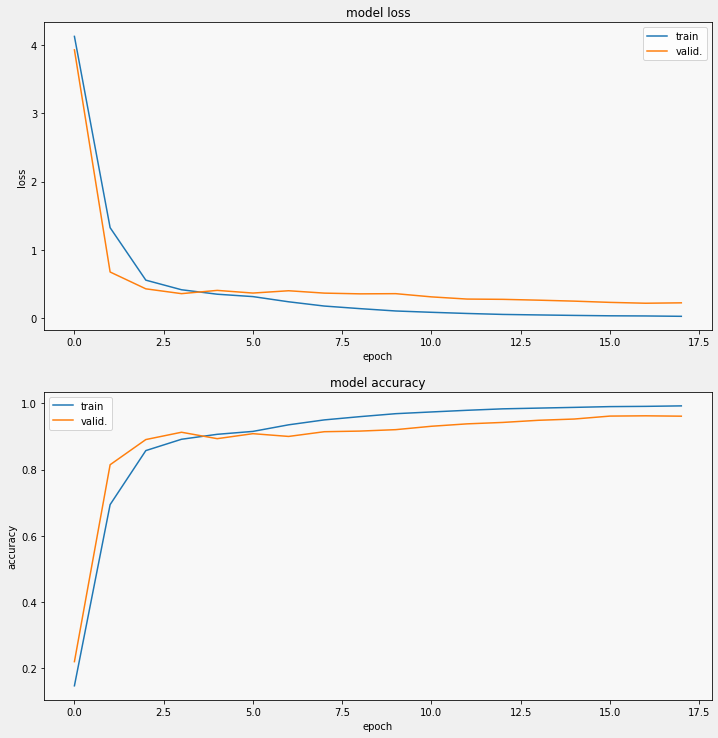

In [19]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

In [20]:
val_probabilities = model.predict(images_ds)
np.save(model_name + '_val_probabilities', val_probabilities)

cm_predictions = np.argmax(val_probabilities, axis = -1)
print('Correct labels: ', cm_correct_labels.shape, cm_correct_labels)
print('Predicted labels: ', cm_predictions.shape, cm_predictions)

Correct labels:  (3712,) [ 50  13  74 ... 102  48  67]
Predicted labels:  (3712,) [ 50  13  74 ... 102  48  67]


In [21]:
def getFitPrecisionRecall(correct_labels, predictions):
    score = f1_score(correct_labels, predictions, labels = range(len(CLASSES)), average = 'macro')
    precision = precision_score(correct_labels, predictions, labels = range(len(CLASSES)), average = 'macro')
    recall = recall_score(correct_labels, predictions, labels = range(len(CLASSES)), average = 'macro')
    return score, precision, recall
#

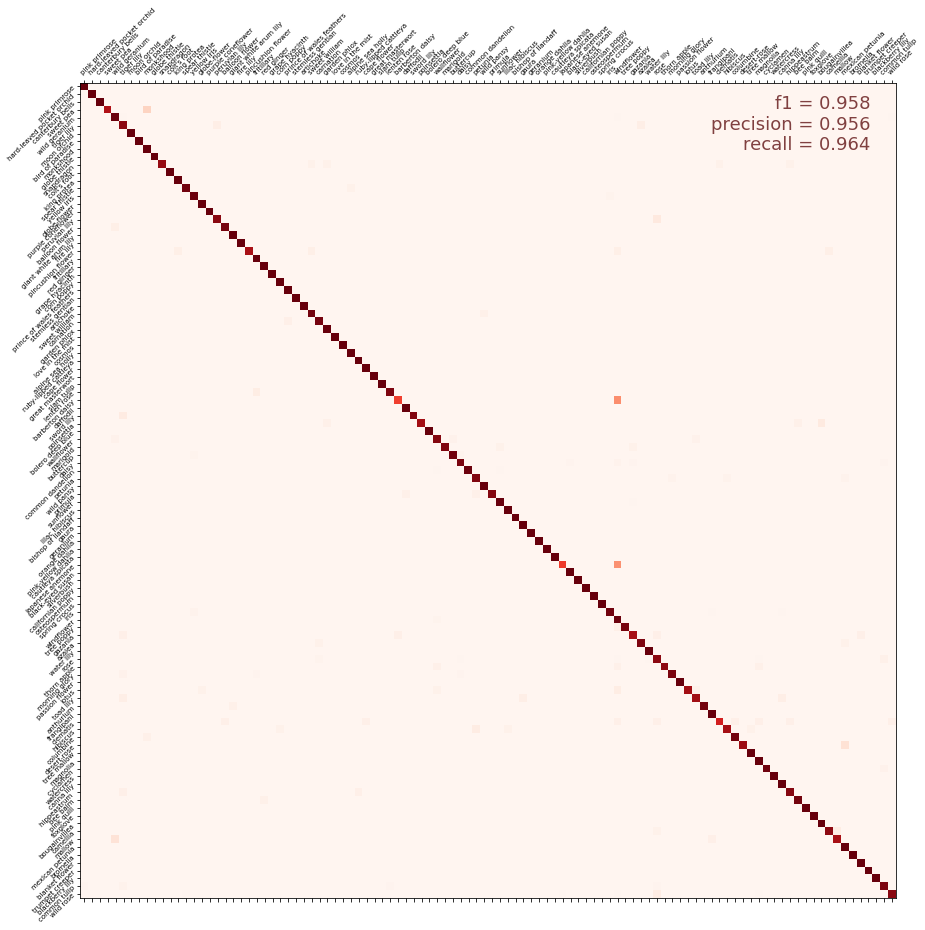

f1 score: 0.958, precision: 0.956, recall: 0.964


In [22]:
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels = range(len(CLASSES)))
score, precision, recall = getFitPrecisionRecall(cm_correct_labels, cm_predictions)
cmat = (cmat.T / cmat.sum(axis = -1)).T
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

In [23]:
def create_submission_file(filename, probabilities):
    predictions = np.argmax(probabilities, axis = -1)
    print('Generating submission file...', filename)
    test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
    test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

    np.savetxt(filename, np.rec.fromarrays([test_ids, predictions]), fmt = ['%s', '%d'], delimiter = ',', header = 'id,label', comments = '')
#

In [24]:
%%time

test_probabilities_no_val = model.predict(test_images_ds)
create_submission_file('submission_no_val.csv', test_probabilities_no_val)

Generating submission file... submission_no_val.csv
CPU times: user 11.4 s, sys: 423 ms, total: 11.8 s
Wall time: 48.6 s


In [25]:
%%time

print('LR_EXP_DECAY:', LR_EXP_DECAY, '. LR_MAX:', LR_MAX)
model.fit(get_validation_dataset(), steps_per_epoch = STEPS_PER_EPOCH, epochs = 25, callbacks = [lr_callback])

LR_EXP_DECAY: 0.8 . LR_MAX: 0.0004
Train for 531 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/25
 29/531 [>.............................] - ETA: 24:41 - loss: 0.2678 - sparse_categorical_accuracy: 0.9356CPU times: user 38.9 s, sys: 1.23 s, total: 40.1 s
Wall time: 1min 25s


In [26]:
%%time

test_probabilities = model.predict(test_images_ds)
create_submission_file('submission.csv', test_probabilities)

Generating submission file... submission.csv
CPU times: user 10.3 s, sys: 446 ms, total: 10.7 s
Wall time: 33.4 s


In [27]:
pklfile = open(model_name + '_test_probs_with_val.pkl', 'ab')
pickle.dump(dict(zip(test_ids, test_probabilities)), pklfile)
pklfile.close()

In [28]:
model.save_weights(model_name + '_weights.h5')